# *Pyrfume* Demo

In [1]:
!pip install -q pyrfume  # Install pyrfume if it is not already installed

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import pyrfume
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

## Part 1: Standardizing your own data
You may already have your own data, and you would like to link the odorants you've used in one dataset with those from other datasets, or simply be able to do analyses that require your odorants to be well-descibed of featurized.

*Pyrfume* operates under the principle that the proper identifier for a single odorant molecule (e.g. d-Limonene) is the PubChem compound ID ([440917](https://pubchem.ncbi.nlm.nih.gov/compound/440917)), for a single (known) mixture (e.g. light mineral oil) is the PubChem substance ID ([402315722](https://pubchem.ncbi.nlm.nih.gov/substance/402315722)).
- A PubChem compound ID uniquely identifiers a molecular structure (unlike a CAS registry number).
- A given structure resolves to only one PubChem ID (unlike a SMILES string which depends on implementation).
- [PubChem](https://pubchem.ncbi.nlm.nih.gov/) itself is indexed by these IDs and provides a wealth of additional records covering experimental data, computable properties, safety information, and other externally linked data.

In order to get access to all of this information, and to link the *same molecule* across datasets, the first step is to obtain PubChem IDs (henceforth, CIDs) for the molecules in question.

In [3]:
names = ['d-limonene', '98-86-2', '(+)-carvone', 'CCCCCC=O', 'GXANMBISFKBPEX-ARJAWSKDSA-N']

Above we have 5 different molecules, represented with a mix of names (with different annotations), CAS numbers, SMILES strings, and InChiKeys.  Your data may use one of these formats, or a mix of them, or some other format entirely.  The [PubChem exchange identifier](https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi) service can do a good job of converting between (some of) these format, or identifying potential CIDs.  Pyrfume does the extra work of auto-identifying the current identifier, checking for alternative conversions, and providing information about names that did not match or had multiple matches.

In [5]:
from pyrfume import get_cids
cids = get_cids(names)

  0%|          | 0/5 [00:00<?, ?it/s]

The process above can be a little bit slow (resolving only a few identifers per second) because the PubChem database itself is not indexed by most of these (only CIDs and InChiKeys).  Still, it returns a dictionary of unique identifiers (CIDs) for each original identifier:

In [7]:
cids

{'d-limonene': 440917,
 '98-86-2': 7410,
 '(+)-carvone': 16724,
 'CCCCCC=O': 6184,
 'GXANMBISFKBPEX-ARJAWSKDSA-N': 643941}

Which looks a bit nicer as a Pandas series

In [10]:
cids = pd.Series(cids)
cids

d-limonene                     440917
98-86-2                          7410
(+)-carvone                     16724
CCCCCC=O                         6184
GXANMBISFKBPEX-ARJAWSKDSA-N    643941
dtype: int64

Now that you have unique identifiers, you can access a lot more information:

In [18]:
from pyrfume import from_cids
info = from_cids(cids.values)

  0%|          | 0/1 [00:00<?, ?it/s]

Retrieving 0 through 4


That part was quite fast and scales very well, because PubChem is indexed by CID.  Pyrfume runs this in batches of 100 CIDs, and each batch takes about 1 second.

In [19]:
molecules = pd.DataFrame(info).set_index('CID')
molecules

,MolecularWeight,IsomericSMILES,IUPACName,name
CID,,,,
440917,136.23,CC1=CC[C@@H](CC1)C(=C)C,(4R)-1-methyl-4-prop-1-en-2-ylcyclohexene,d-limonene
7410,120.15,CC(=O)C1=CC=CC=C1,1-phenylethanone,acetophenone
16724,150.22,CC1=CC[C@@H](CC1=O)C(=C)C,(5S)-2-methyl-5-prop-1-en-2-ylcyclohex-2-en-1-one,d-carvone
6184,100.16,CCCCCC=O,hexanal,hexanal
643941,98.14,CC/C=C\CC=O,(Z)-hex-3-enal,cis-3-hexenal


The above contains the original set of molecules, indexed by CID, but also containing some other useful identifiers that (unlike CAS or InChiKey) actually tell you something about the molecule in question just by looking at them.  The "IsomericSMILES" columns is standardized SMILES string computed using the same software (on PubChem) for every molecule.  The "[IUPACName](https://en.wikipedia.org/wiki/IUPAC_nomenclature_of_organic_chemistry)" is similarly, a standardized nomenclature for molecle names.  "name" is simply the most common name (sometimes a trade name) of the molecule, as you might see it in a publication.  CID, IsomericSMILES, and IUPACName, all uniquely describe the molecule.  If you have multiple datasets from multiple sources, and you want to integrate them together, you can use stock Pandas functions for merging and/or concatenating data. 

This representation for a set of molecules will recur again and again in Part 4, when looking at external datasets.

## Part 2: Featurization for machine learning

Many applications, such as predictive models, propose that molecular structure of an odorant is causal to neural activity or behavior (a reasonable proposition).  Training these models requires that each molecule be represented by a vector of predictors, or features, which in some way describe the structure quantitatively.  Traditionally the chemoinformatic feature-calculation software called [Dragon](https://chm.kode-solutions.net/pf/dragon-7-0/) has been used for this, but since Dragon is commercial software this creates challenges for replication and reproducibility.  Some have found that open source feature-calculation packages such as [Mordred](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y) perform as or nearly as well.  

Feature-calculation on molecules involves several steps including 1) expression of structure in a standard representation (such as SMILES or InChi), 2) conversion of that structure to a molecule object in memory (e.g. [rdkit](https://www.rdkit.org/) Mol), 3) addition of hydrogens (omitted from the SMILES by design), removal of salts, etc. 4) embedding in 3 dimensions (without violating steric or electostatic principles), 5) feature calculation on this 3d structure.  *Pyrfume* abstracts all of this away into one step.

In [37]:
smiles = molecules['IsomericSMILES'].tolist()
smiles

['CC1=CC[C@@H](CC1)C(=C)C',
 'CC(=O)C1=CC=CC=C1',
 'CC1=CC[C@@H](CC1=O)C(=C)C',
 'CCCCCC=O',
 'CC/C=C\\CC=O']

In [28]:
from pyrfume.features import smiles_to_mordred
mordred_features = smiles_to_mordred(smiles)

  0%|          | 0/5 [00:00<?, ?it/s]


Computing Mordred features...




  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00,  9.81it/s]


There are 5 molecules and 1826 features


The code above implements all of the steps required for featurization (except for obtaining the SMILES string, which was done in Part 1).  One can also obtain a SMILES string directly by calling `pyrfume.odorants.cids_to_smiles`.

In [29]:
mordred_features

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
CC1=CC[C@@H](CC1)C(=C)C,7.358797,6.909742,0,0,11.936238,2.236068,4.472136,11.936238,1.193624,3.197236,...,8.815964,39.140584,136.125201,5.235585,120,11,46.0,50.0,4.333333,2.277778
CC(=O)C1=CC=CC=C1,6.542301,6.236096,0,0,11.189957,2.193993,4.387987,11.189957,1.243329,3.089765,...,8.590258,37.289972,120.057515,7.062207,88,9,40.0,43.0,3.472222,2.111111
CC1=CC[C@@H](CC1=O)C(=C)C,8.134854,7.731889,0,0,13.152542,2.292456,4.584911,13.152542,1.195686,3.294652,...,9.071423,40.991311,150.104465,6.004179,152,14,52.0,58.0,5.194444,2.472222
CCCCCC=O,4.242641,4.53095,0,0,8.054679,1.847759,3.695518,8.054679,1.150668,2.739193,...,6.900731,30.25721,100.088815,5.267832,56,4,22.0,20.0,3.25,2.0
CC/C=C\CC=O,4.242641,4.53095,0,0,8.054679,1.847759,3.695518,8.054679,1.150668,2.739193,...,6.900731,30.25721,98.073165,5.76901,56,4,22.0,20.0,3.25,2.0


The `mordred_features` Pandas dataframe has (for the current version of Mordred, installed by Pyrfume) 1826 computed physicochemical features for each molecule.  What do these features mean?  That's a question for the computational chemists.  As investigators asking how molecular structure might explain or be represented in brain activity or behavior, we just want a set of predictors with a track record of success in structure-based predictive models.

It has been shown previously that the physics-based features of Dragon (or of Mordred, which implements similar calculations) are good at predicting some kinds of structure-driven outcomes, but not others.  For example, in [Keller et al 2017 (Science)](https://science.sciencemag.org/content/355/6327/820.abstract) it was shown that such features are good for predicting perceived intensity, but not as good at predicting perceived "bakery" smell.  That paper showed that the latter was better predicted by a template-matching approach -- molecules that smell like "bakery" are best predicted by asking whether they are structurally similar to other molecules known to smell like "bakery".  

In [33]:
from pyrfume.features import smiles_to_morgan
morgan_features = smiles_to_morgan(smiles)

  0%|          | 0/5 [00:00<?, ?it/s]

Computing Morgan Fingerprints:   0%|          | 0/5 [00:00<?, ?it/s]

In [34]:
morgan_features

,10565946,56091288,118067289,121328373,153234704,180311863,226893386,245578872,256538328,269476445,...,3910734833,3967719433,3983702751,3990544841,4056449865,4084831613,4166400509,4175270308,4209952873,4277593716
CC1=CC[C@@H](CC1)C(=C)C,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,16.0
CC(=O)C1=CC=CC=C1,0.0,5.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
CC1=CC[C@@H](CC1=O)C(=C)C,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,14.0
CCCCCC=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,12.0
CC/C=C\CC=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0


The dataframe above contains fragment counts, i.e. the number of times, within each molecule (represented by a SMILES string) that a given sub-molecular pattern (e.g. an acetyl group, a benzene ring, or any other possible substructure) occurs.  Each substructure has a unique "hash", which is simply a long integer that can be resolved to that sub-structure (also called a [fingerprint](https://towardsdatascience.com/a-practical-introduction-to-the-use-of-molecular-fingerprints-in-drug-discovery-7f15021be2b1)).  The larger and more diverse the number of molecules that we want to featurize, the larger the number of potential substructures, so the number of predictors can become quite larger (here since we are only working with 5 molecules, there are only 105 unique substructures, of some maximum size).

These features can be used directly, but they still don't tell us how similar two molecules are.

In [39]:
from pyrfume.features import smiles_to_morgan_sim
morgan_sim_features = smiles_to_morgan_sim(smiles, smiles)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [40]:
morgan_sim_features

,CC1=CC[C@@H](CC1)C(=C)C,CC(=O)C1=CC=CC=C1,CC1=CC[C@@H](CC1=O)C(=C)C,CCCCCC=O,CC/C=C\CC=O
CC1=CC[C@@H](CC1)C(=C)C,1.000000,0.272000,0.680556,0.360656,0.372881
CC(=O)C1=CC=CC=C1,0.272000,1.000000,0.308943,0.297030,0.309278
CC1=CC[C@@H](CC1=O)C(=C)C,0.680556,0.308943,1.000000,0.383333,0.396552
CCCCCC=O,0.360656,0.297030,0.383333,1.000000,0.574468
CC/C=C\CC=O,0.372881,0.309278,0.396552,0.574468,1.000000


By using `smiles_to_morgan_sim` we have the option of a second argument, which is a list of SMILES to compare the original SMILES to.  The result is a measure of similarity between two molecules, defined as their similarity in substructure counts.

But rather than restrict the the similarity to only those molecules we want to predict, why not compute the similarity to other known odorous (or non-odorous) molecules?

In [47]:
from pyrfume.odorants import all_smiles
reference_smiles = all_smiles()
#smiles_to_morgan_sim(smiles, reference_smiles)

The code above (after uncommenting the last line) will compute a dataframe of similarities between your molecule of interest and several thousand known odorants curated through the Pyrfume project.  This list consists of odorants used in [>40 notable journal articles and industrial databases](http://status.pyrfume.org).  

Because this list is so large, there is a good chance that all of the molecules you are using for your project are already in it.  This means that the feature values can be computed once and you can simply look them up.  These pre-computed values have already been filtred to remove non-informative (e.g. zero variance) features or features with a large fraction of missing values (some features, especially for Mordred, are only computable for esoteric molecules). Furthermore, the remaining missing values have been filled with [KNN imputation](https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e).  This means that they are "ready to go" for machine learning applications (which typically require finite and non-missing values in all predictors).

In [48]:
morgan_sim = pyrfume.load_data('morgan/features_sim.csv')

In [96]:
mordred = pyrfume.load_data('mordred/features.csv')

These files are quite large (thousands of molecules (rows) by thousands of features (columns)) and may take a minute to load.  Directly querying the pyrfume database, rather than loading the entire files, would be faster and is documented separately.

In [52]:
morgan_sim_ = morgan_sim.loc[cids]
mordred_ = mordred.loc[cids]

Because every stored value in Pyrfume is indexed by CID, we can access the molecules we care about (that we want to get features for) using CIDs as keys.  We can then join them to produce one final set of features for machine learning applications.

In [53]:
features = mordred_.join(morgan_sim_)
features

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,CC(=O)O.C1=CC=C2C(=C1)C(=CC3=C2N=C4C=CC(=N)C=C4O3)N,CCC(C)N1CCC2(CC1)NC3=C4C5=C(C(=NC(=O)/C(=C/C=C/[C@@H]([C@@H]([C@H]([C@H]([C@H]([C@@H]([C@@H]([C@H](/C=C/O[C@@]6(C(=O)C4=C(O6)C(=C5O)C)C)OC)C)OC(=O)C)C)O)C)O)C)/C)C3=N2)O,C[C@H]1/C=C/C=C(\C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=O)[C@](O4)(O/C=C/[C@@H]([C@H]([C@H]([C@@H]([C@@H]([C@@H]([C@H]1O)C)O)C)OC(=O)C)C)OC)C)C)O)O)/C=N\N5CCN(CC5)C)/C,C[C@H]1/C=C/C=C(\C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=O)[C@](O4)(O/C=C/[C@@H]([C@H]([C@H]([C@@H]([C@@H]([C@@H]([C@H]1O)C)O)C)OC(=O)C)C)OC)C)C)O)O)/C=N\N5CCN(CC5)C6CCCC6)/C,COC1=CC(=CC(=C1O)OC)/C=N\N=C/C2=CC(=C(C(=C2)OC)O)OC,C[N+]1=CC=CC=C1/C=N\O.[Cl-],COC(=O)N/N=C\C1=[N+](C2=CC=CC=C2[N+](=C1)[O-])[O-],C1=CC(=C(C(=C1)Cl)CC(=O)NC(=N)N)Cl.Cl,C1(=C(N=C(C(=N1)Cl)N)N)C(=O)NC(=N)N.O.O.Cl,CCCCCCCOC1=C(C=C(C=C1)CC=C)OC
CID,,,,,,,,,,,,,,,,,,,,,
440917,7.358797,6.909742,0.0,0.0,11.936238,2.236068,4.472136,11.936238,1.193624,3.197236,...,0.139303,0.174089,0.185263,0.178218,0.257261,0.266667,0.218579,0.222222,0.160000,0.289593
7410,6.542301,6.236096,0.0,0.0,11.189957,2.193993,4.387987,11.189957,1.243329,3.089765,...,0.288889,0.114165,0.123348,0.115702,0.254545,0.456140,0.395062,0.409091,0.232558,0.250000
16724,8.134854,7.731889,0.0,0.0,13.152542,2.292456,4.584911,13.152542,1.195686,3.294652,...,0.150754,0.174797,0.190275,0.178926,0.251046,0.285714,0.243094,0.251656,0.189189,0.283105
6184,4.242641,4.530950,0.0,0.0,8.054679,1.847759,3.695518,8.054679,1.150668,2.739193,...,0.124294,0.144681,0.141907,0.133056,0.267281,0.270270,0.226415,0.232558,0.174603,0.385787
643941,4.242641,4.530950,0.0,0.0,8.054679,1.847759,3.695518,8.054679,1.150668,2.739193,...,0.115607,0.103004,0.111857,0.104822,0.225352,0.280374,0.245161,0.256000,0.196721,0.279793


We now have one giant dataframe with all 10000+ features (all physicochemical features for Mordred and all Morgan fingerprint similarity features), indexed by CID.  You are now ready for prediction on targets (receptor activation, glomerular imaging data, PCx firing rates, human perception, animal behavior, etc.) using your favoriate ML framework (scikit-learn, pytorch, etc.)

*Pyrfume* also supports some additional featurizations (e.g. [NSPDK](https://dtai.cs.kuleuven.be/drupal/software/nspdk)) and is working on supporting more (e.g. from [Graph Convolution Networks](https://arxiv.org/abs/1910.10685) or [Auto-Encoders](https://www.biorxiv.org/content/10.1101/464735v1)).

## Part 3: Visualization

Now that our molecules have standard representations (from Part 1), we can easily visualize them:

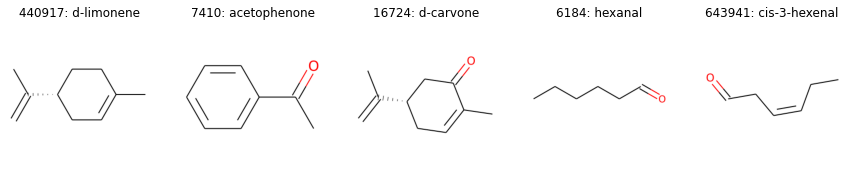

In [85]:
from pyrfume.odorants import display_molecules
display_molecules(molecules)

Or we can ask where they live in low-dimensional spaces built from features, compared with other odorous molecules.

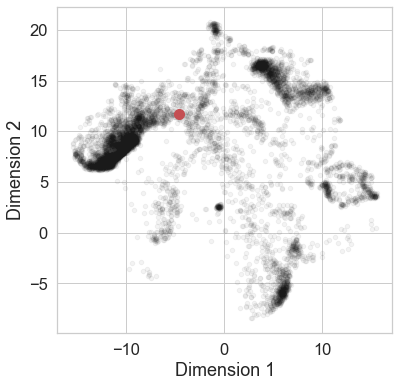

In [130]:
from pyrfume.odorants import embed_molecules
acetophenone = molecules.loc[[7410]]
embed_molecules(acetophenone)

The above shows thousands of molecules from the Pyrfume database (black) and acetophenone in red, using a 2-dimensional [UMAP embedding](https://umap-learn.readthedocs.io/en/latest/) built from those thousands of molecules.

## Part 4: Working with the Pyrfume datasets

Whether you want to build predictive models or simply organize data, it is essential to begin integrating across datasets and wherever possible bringing the largest datasets to bear on the problem.  Most breakthroughs [don't come from new algorithms but from new, large datasets](https://academic.oup.com/chemse/article/doi/10.1093/chemse/bjab020/6226923?login=true).

In [59]:
bushdid_molecules = pyrfume.load_data('bushdid_2014/molecules.csv')
bushdid_molecules.head()

,MolecularWeight,IsomericSMILES,IUPACName,name,Odorant name,C.A.S.,% odorant,Solvent
CID,,,,,,,,
176,60.05,CC(=O)O,acetic acid,acetic acid,acetic acid,64-19-7,10.00,mineral oil
177,44.05,CC=O,acetaldehyde,acetaldehyde,acetaldehyde,75-07-0,5.00,water
179,88.11,CC(C(=O)C)O,3-hydroxybutan-2-one,acetoin,acetoin,513-86-0,0.10,"1,2-propanediol"
180,58.08,CC(=O)C,propan-2-one,acetone,propan-2-one,67-64-1,25.00,water
240,106.12,C1=CC=C(C=C1)C=O,benzaldehyde,benzaldehyde,benzaldehyde,100-52-7,0.25,mineral oil


The above shows the first 5 molecules (all 128 are in the full dataframe) from [Bushdid et al, 2014](https://science.sciencemag.org/content/343/6177/1370.long) which looked at the perceptual discriminability of random mixtures in humans.  The first thing to note is that the index and the first 5 columns are structured identically to what we generated in Part 1 from our own data.  ALL *pyrfume* datasets have this structure, whether there were obtained from supplemental figures and tables, excel files or pdfs, industrial databases, books, or papyrus scrolls.  Additional columns (such as the final 4 shown above) may also be present, on case-by-case basis, depending on what the authors chose to include in their source materials.

What else has the `Pyrfume` project extracted from this data source?

In [60]:
pyrfume.show_files('bushdid_2014')

{'behavior': {'csv': 'Triangle test results'},
 'main': {'ipynb': 'Processing workflow'},
 'mixtures': {'csv': 'Mixtures used'},
 'molecules': {'csv': 'Molecules used'}}


The above shows a manifest of files available.  Curated file names are simple and memorable (typically, "molecules", "behavior", "imaging", etc.) which means you will often not even need to examine the manifest before retrieving the files you care about.  Importantly, every data archive contains at least one notebook ([`main.ipynb`](https://github.com/pyrfume/pyrfume-data/blob/master/bushdid_2014/main.ipynb)) which provides the full processing workflow going from the raw data provided in the original data source to the cleaned, standardized, organized and mutually compatible datasets provided by *Pyrfume*.

In [64]:
bushdid_mixtures = pyrfume.load_data('bushdid_2014/mixtures.csv')
bushdid_behavior = pyrfume.load_data('bushdid_2014/behavior.csv')

Information about each mixture, including the CID (not provided in the original source data) is given in the mixtures file.

In [65]:
bushdid_mixtures.head()

,Answer,Components in mixtures,Components that differ,% mixture overlap,Stimulus dilution,Molecule 1,Molecule 2,Molecule 3,Molecule 4,Molecule 5,...,Molecule 21,Molecule 22,Molecule 23,Molecule 24,Molecule 25,Molecule 26,Molecule 27,Molecule 28,Molecule 29,Molecule 30
Test UID,,,,,,,,,,,,,,,,,,,,,
1,right,30,30,0.0,1.00,12232,7731,7888,7966,7848,...,8103,7344,8051,7921,460,7583,11002,12367,6590,7991
1,wrong,30,30,0.0,0.25,440917,5281515,8030,3314,31272,...,6561,22386,11509,443162,8797,16666,7749,7793,7799,7762
1,wrong,30,30,0.0,0.50,440917,5281515,8030,3314,31272,...,6561,22386,11509,443162,8797,16666,7749,7793,7799,7762
2,right,10,4,60.0,0.50,3314,62433,5281515,7749,6561,...,0,0,0,0,0,0,0,0,0,0
2,wrong,10,4,60.0,0.25,3314,62433,5281515,7749,6561,...,0,0,0,0,0,0,0,0,0,0


Finally, the human behavioral results for each mixture are provided in the behavior file.  How one chooses to join these tables to produce prediction target or otherwise explore the data is up to individual taste, but with standards in place it is much less work than it would have been with the source data alone!

In [66]:
bushdid_behavior.head()

,Subject,Correct
Test UID,,
1,1,False
1,2,True
1,3,False
1,4,True
1,5,True


Many other datasets are available now, with several dozen additional datasets ready for release in the next 12 months.  Licensing issues stand in the way of some, but the *Pyrfume* maintainers are working this out. 

In [68]:
pyrfume.list_archives()

['abraham_2012',
 'bushdid_2014',
 'haddad_2008',
 'keller_2016',
 'manoel_2021',
 'ravia_2020',
 'snitz_2013',
 'wakayama_2019']